# Adtracking Fraud Detection

by Kyle O'Brien, Catherine Lee, Amit Saxena 

Data is in "data/" and includes the training and testing csv files.
Evaluation metrics will include looking at R^2 and a confusion matrix. Other things to try, CNN (Resnet, inceptionv3)

In [51]:
import numpy as np         # linear algebra
import sklearn as sk       # machine learning
import pandas as pd        # reading in data files, data cleaning
import matplotlib.pyplot as plt   # for plotting
import seaborn as sns      # visualization tool
import tensorflow as tf
import keras



Train_sample: 100,000 randomly-selected rows of training data (because the full training data takes too long)

In [52]:
#load data in 

data = pd.read_csv("data/equalized_train.csv")

data.head()


,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83252,3,1,16,379,2017-11-06 15:42:19,NaN,0
1,106590,3,1,25,379,2017-11-06 15:43:23,NaN,0
2,147164,14,1,28,134,2017-11-06 16:00:00,NaN,0
3,39782,2,1,10,205,2017-11-06 16:00:00,NaN,0
4,121646,23,1,13,153,2017-11-06 16:00:00,NaN,0


In [53]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91473 entries, 0 to 91472
Data columns (total 8 columns):
ip                 91473 non-null int64
app                91473 non-null int64
device             91473 non-null int64
os                 91473 non-null int64
channel            91473 non-null int64
click_time         91473 non-null object
attributed_time    41473 non-null object
is_attributed      91473 non-null int64
dtypes: int64(6), object(2)
memory usage: 5.6+ MB


Dropping attributed_time because many null values

# Feature Engineering for Click Time

In [111]:
# Parsed `click_time` feature to seconds since epoch
# Stored new column in `click_time_epoch`
from datetime import datetime, timezone

def epoch_distance(iso):
    dt = datetime.strptime(iso,"%Y-%m-%d %H:%M:%S")
    dt.replace(tzinfo=timezone.utc)
    return dt.timestamp()

def day_seconds(timestamp):
    dt = datetime.fromtimestamp(timestamp,timezone.utc)
    return dt.hour*3600 + dt.minute*60 + dt.second

def day_minutes(timestamp):
    return round(day_seconds(timestamp) / 60)

# Entry Point
def feature_engineer_click_time(data, in_minutes=False):    
    #convert click_time to seconds since epoch
    data['click_time_epoch'] =  data['click_time'].map(epoch_distance)

    # parsed `click_time` feature to seconds of the current day
    # stored new column in `click_time_secs`
    data['click_time_secs'] =  data['click_time_epoch'].map(day_seconds)
    
    if in_minutes is True:
        # parsed `click_time` feature to minutes of the current day
        # stored new column in `click_time_mins`
        data['click_time_mins'] =  data['click_time_epoch'].map(day_minutes)


In [112]:
feature_engineer_click_time(data)


In [113]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91473 entries, 0 to 91472
Data columns (total 11 columns):
ip                  91473 non-null int64
app                 91473 non-null int64
device              91473 non-null int64
os                  91473 non-null int64
channel             91473 non-null int64
click_time          91473 non-null object
attributed_time     41473 non-null object
is_attributed       91473 non-null int64
click_time_epoch    91473 non-null float64
click_time_secs     91473 non-null int64
click_time_mins     91473 non-null int64
dtypes: float64(1), int64(8), object(2)
memory usage: 7.7+ MB


In [57]:
data.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,click_time_epoch,click_time_secs,click_time_mins
0,83252,3,1,16,379,2017-11-06 15:42:19,NaN,0,1.509983e+09,56539,942
1,106590,3,1,25,379,2017-11-06 15:43:23,NaN,0,1.509983e+09,56603,943
2,147164,14,1,28,134,2017-11-06 16:00:00,NaN,0,1.509984e+09,57600,960
3,39782,2,1,10,205,2017-11-06 16:00:00,NaN,0,1.509984e+09,57600,960
4,121646,23,1,13,153,2017-11-06 16:00:00,NaN,0,1.509984e+09,57600,960


# Recursive Feature Elimination

# Understanding our Dataset

In [58]:
#data = data.drop(columns=['attributed_time'])
#data.info()

In [59]:
data['is_attributed'].describe()

count    91473.000000
mean         0.453391
std          0.497826
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: is_attributed, dtype: float64

In [60]:
#plotx = data['attributed_time']
#ploty = data['is_attributed']

#plt.scatter(plotx,ploty)
import pandas
class_counts = data.groupby('is_attributed').size()
print(class_counts)

is_attributed
0    50000
1    41473
dtype: int64


This confirms that we have a major imbalance in our data. This is incentivising our model to guess 0 for overthing and it would still receive a 99% accuracy

# Logistic Regression

In [61]:
X = data[['app', 'device', 'os', 'channel', 'click_time_secs']]
y = data['is_attributed']

In [62]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

In [63]:
X_train.head()

,app,device,os,channel,click_time_secs
22243,2,1,20,477,61028
58933,105,1,17,451,33458
50574,18,3032,607,107,74066
63812,11,1,13,325,58608
52847,116,1,41,101,5858


In [64]:
y_train.head()

22243    0
58933    1
50574    0
63812    1
52847    1
Name: is_attributed, dtype: int64

In [65]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

In [66]:
logreg.fit(X_train, y_train)


/root/.local/share/virtualenvs/fraud_detection-yH1T5P0u/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [67]:
predictions = logreg.predict(X_test)

Seems a little strange that we would get such high accuracy. This might have to do with the fact that we are using R^2 to measure the goodness of our model. There might be an imbalance in the test set of which clicks are 0 or 1, so we should try precision and recall. (Longterm with full training data, try to keep an equal number of classes)

In [68]:
logreg_score = logreg.score(X_test, y_test)
print("Logistic Regression Accuracy", logreg_score)

Logistic Regression Accuracy 0.8567368133369773


# Random forest

In [69]:
from sklearn.ensemble import RandomForestClassifier
RandomForest = RandomForestClassifier()
RandomForest.fit(X_train,y_train)
rf_score = RandomForest.score(X_test,y_test)
print("Random Forest accuracy:", rf_score)

/root/.local/share/virtualenvs/fraud_detection-yH1T5P0u/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest accuracy: 0.9864443837113965


In [70]:
# Precision Recall Score
from sklearn.metrics import classification_report

y_pred = RandomForest.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      9971
           1       0.99      0.98      0.98      8324

   micro avg       0.99      0.99      0.99     18295
   macro avg       0.99      0.99      0.99     18295
weighted avg       0.99      0.99      0.99     18295



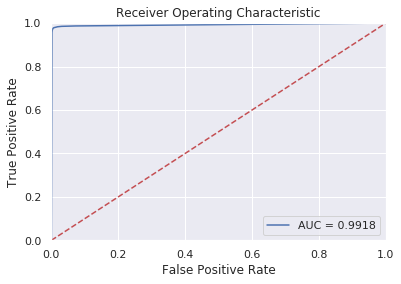

In [71]:
from sklearn.metrics import roc_curve, auc


# Visualizing through AOC - ROC chart (Area Under Curve - Receiver Operating Characteristics)

# An AOC of 1 means our model performs perfectly and an AOC of .45 means we have no discriminate classification and an AOC
# of 0 means we are predicting the exact opposite of correct values


proba = RandomForest.predict_proba(X_test)
proba = np.delete(proba, 0, 1)

fpr, tpr, thresh = roc_curve(y_test,proba)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
sns.set()




As demonstrated from the ROC graph, RandomForests achieve an AUC of almost close to 1 which means that we're predicting labels correctly 96% of the time.  This is very good.  

# Support Vector Machine

In [72]:
from sklearn.svm import LinearSVC 

In [73]:
lSVC = LinearSVC()

In [74]:
lSVC.fit(X_train,y_train)
svm_score = lSVC.score(X_test,y_test)
print("SVM accuracy:", svm_score)

SVM accuracy: 0.8010931948619842


/root/.local/share/virtualenvs/fraud_detection-yH1T5P0u/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


# Decision Tree

In [75]:
from sklearn import tree
dtc = tree.DecisionTreeClassifier()

dtc = dtc.fit(X_train,y_train)
dtc_score =  dtc.score(X_test,y_test)
print("Decision Tree Accuracy:", dtc_score)

Decision Tree Accuracy: 0.9802678327411861


In [76]:
# Precision Recall Score
from sklearn.metrics import classification_report

y_pred = dtc.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      9971
           1       0.98      0.98      0.98      8324

   micro avg       0.98      0.98      0.98     18295
   macro avg       0.98      0.98      0.98     18295
weighted avg       0.98      0.98      0.98     18295



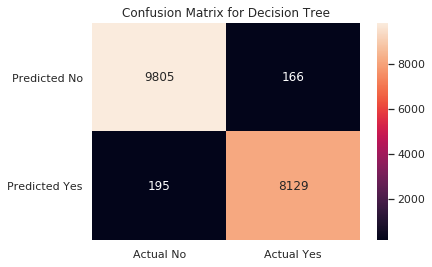

In [77]:
# Confusion Matrix for Decision Trees

from sklearn.metrics import confusion_matrix


cmat = confusion_matrix(y_test, y_pred)
plt.title("Confusion Matrix for Decision Tree")

annot = pd.DataFrame(cmat)

ax = sns.heatmap(cmat, annot=annot, fmt="d", xticklabels=['Actual No', 'Actual Yes'], yticklabels=['Predicted No', 'Predicted Yes'])
ax.tick_params(axis='y', rotation=0)


# KNN

In [78]:
from sklearn import neighbors

knn = neighbors.KNeighborsClassifier()
knn.fit(X_train, y_train)
Y_pred = knn.predict(X_test)
knn_score = knn.score(X_test, y_test)


# Gaussian Naive Bayes

In [79]:
from sklearn.naive_bayes import GaussianNB
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
Y_pred = gaussian.predict(X_test)
gaussian_score = gaussian.score(X_test, y_test) 

# SGD

In [92]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier()
sgd.fit(X_train, y_train)
Y_pred = sgd.predict(X_test)
sgd_score = sgd.score(X_test, y_test)

/root/.local/share/virtualenvs/fraud_detection-yH1T5P0u/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


# Perceptron

In [89]:
from sklearn.linear_model import Perceptron

perceptron = Perceptron()
perceptron.fit(X_train, y_train)
Y_pred = perceptron.predict(X_test)
perc_score = perceptron.score(X_test, y_test)


/root/.local/share/virtualenvs/fraud_detection-yH1T5P0u/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.6224651544137743

# XGBoost

In [93]:
import xgboost as xgb



XGB = xgb.XGBClassifier()
XGB.fit(X_train, y_train)
Y_pred = XGB.predict(X_test)
XGB_score = XGB.score(X_test,y_test)


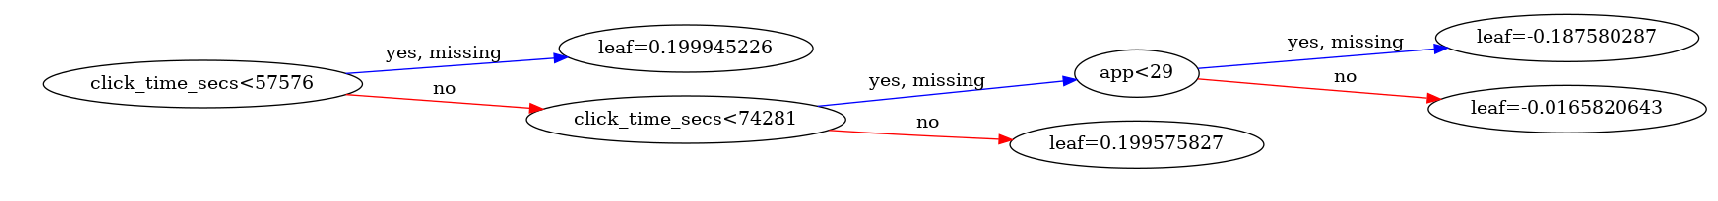

In [83]:
from xgboost import plot_tree



import graphviz
# Visualizing xgboost decisision trees using graphiviz library

# Visualizing the first boosted tree (least sophisticated)
fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(XGB, ax=ax, num_trees=0 , rankdir='LR')
plt.show()


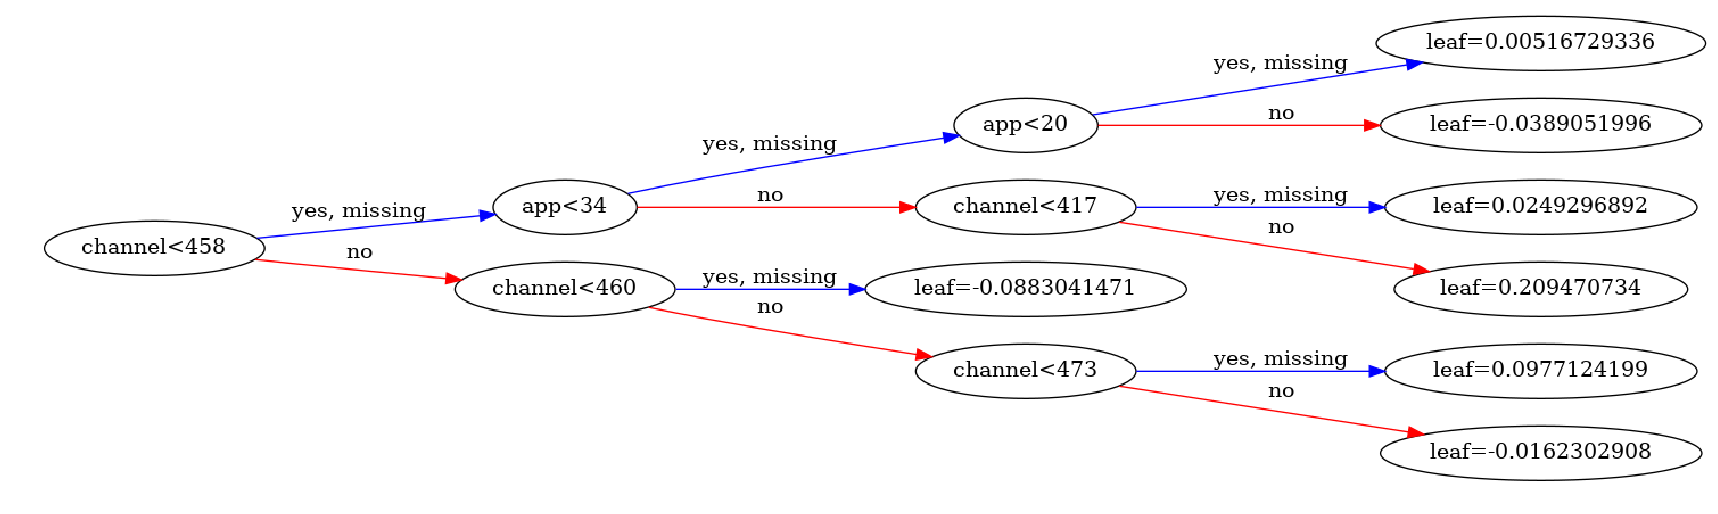

In [84]:
# visualizing the last boosted tree (most sophisticated)
fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(XGB, ax=ax, num_trees=99 , rankdir='LR')
plt.show()

# Gradient Boosted Trees

In [95]:
from sklearn.ensemble import GradientBoostingClassifier
gbt = GradientBoostingClassifier()
gbt = gbt.fit(X_train, y_train)
gbt_acc = gbt.score(X_test, y_test)

# Voting Classifier/ Ensemble Learning

In [103]:
from sklearn.ensemble import VotingClassifier

#dictionary of our models
model1 = xgb.XGBClassifier()
model2 = tree.DecisionTreeClassifier()
model3 = RandomForestClassifier() 
estimators=[('xgboost', model1), ('decisiontree', model2), ('randomforest', model3)]

#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='hard')


# Adaboost

In [104]:
from sklearn.ensemble import AdaBoostClassifier

adaboost = AdaBoostClassifier(n_estimators=100).fit(X_train,y_train)
adaboost_acc = adaboost.score(X_test,y_test)


# Bagging Classifer

In [106]:
from sklearn.ensemble import BaggingClassifier
bag = BaggingClassifier()
bag = bag.fit(X_train,y_train)
bag_acc = bag.score(X_test,y_test)

# Extra Trees Classifier

In [107]:
from sklearn.ensemble import ExtraTreesClassifier
xtrees = ExtraTreesClassifier.fit(X_train,y_train)
xtrees_acc = xtrees.score(X_test,y_test)

TypeError: fit() missing 1 required positional argument: 'y'

# Which model do we use?

In [108]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'Logistic Regression', 
              'Random Forest', 'Linear SVC', 
              'Decision Tree', 'K Nearest Neighbors', 
              'Gaussian Naive Bayes', 'Stochastic Gradient Descent', 
              'Perceptron', 'XGBoost', 'Gradient Boosted Trees', 'Adaboost', 'Bagging Classifier'],
    'Score': [svm_score, logreg_score, rf_score, svm_score, dtc_score, 
              knn_score, gaussian_score, sgd_score, perc_score, 
              XGB_score, gbt_acc, adaboost_acc, bag_acc]})
models.sort_values(by='Score', ascending=False)

,Model,Score
2,Random Forest,0.986444
10,Gradient Boosted Trees,0.986116
12,Bagging Classifier,0.986116
9,XGBoost,0.985624
11,Adaboost,0.984422
4,Decision Tree,0.980268
5,K Nearest Neighbors,0.971850
6,Gaussian Naive Bayes,0.947636
1,Logistic Regression,0.856737
0,Support Vector Machines,0.801093


# Neural Network

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

#60,30,1 --> .9156 acc with .234 loss
#20,10,1 --> .9122 acc, .2576 loss
#10,5,1 --> val: .9064 acc, .279 loss
#30,10,1 --> .9117 acc, .239 loss
#60,10,1 --> .918 acc , .230 loss
#70,10,1 --> .913, .238
#50,10,1 --> .917 , .229
#40,10,1 --> .918, .228
model = Sequential()
model.add(Dense(40, activation='sigmoid', input_dim = 4))
model.add(Dense(10,activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))


# can try rmsprop
model.compile(optimizer = 'adam',     
              loss = 'binary_crossentropy',
              metrics = ['accuracy']) 

# Train the model, iterating on the data in batches of 32 samples
history = model.fit(X_train, y_train, 
                    validation_split = 0.33, 
                    epochs = 300, 
                    batch_size = 32)

# Evaluate the model's performance
train_loss, train_acc = model.evaluate(X_train, y_train)
test_loss, test_acc = model.evaluate(X_test, y_test)


print('Training set accuracy:', train_acc)
print('Training set loss:', train_loss)

print('Test set accuracy:', test_acc)
print('Test set loss:', test_loss)



In [ ]:
# The history of our accuracy during training.
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# The history of our cross-entropy loss during training.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Ensemble Learning

# Submitting to Kaggle with best model

In [ ]:
import pandas as pd
true_test = pd.read_csv("data/test.csv")

#also remember to pickle model for kyle

In [ ]:
test.info()

In [ ]:
true_test_X = true_test[['app', 'device', 'os', 'channel']]

true_test_predictions = model.predict(true_test_X)

In [ ]:
submission = pd.DataFrame({
        "click_id,is_attributed": true_test_predictions
    }).to_csv('prediction.csv')
# saves to prediction.csv
